## DQNを用いた二自由度マニピュレータの動作計画

In [8]:
# 0) 必要ライブラリのインポート
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pygame
import sys
import traceback
import matplotlib.pyplot as plt
import japanize_matplotlib

from env import Arm2DEnv
from dqn import DQN
from buffer import ReplayBuffer
from visualization import ArmViewer

In [2]:
# 1) 行動を選択(ε-greedy法を使用)
def select_action(model, state, action_dim, epsilon=0.2):
    # 探索
    if np.random.rand() < epsilon:
        return np.random.randint(action_dim)
    
    # 活用
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_values = model(state) # 各行動のq値を取得 (action_dim, )
    return int(q_values.argmax(dim=1).item())

In [3]:
# 2) 環境の実体化
env = Arm2DEnv()
input_dim = env.get_state().shape[0]
action_dim = len(env.action_space)
print(f"input_dim: {input_dim}, action_dim: {action_dim}")

# 3) DQNとtarget networkのモデル定義
model = DQN(input_dim, action_dim)
target_net = DQN(input_dim, action_dim)
target_net.load_state_dict(model.state_dict()) # モデルと同じパラメータにさせる
target_net.eval()  # データを取って来るだけなので、評価モードに設定

# 4) 最適化アルゴリズムのセット
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 5) ハイパパラメータのセット
BATCH_SIZE = 64
GAMMA = 0.99
INIT_EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.998
TARGET_UPDATE_REQ = 10
EPISODES = 10_000
MAX_STEP = 400
WARMUP = 2_000  # 学習開始するまでの最低ステップ数

# 6) バッファのセット
buffer = ReplayBuffer(BATCH_SIZE, capacity=10_000)

# ログ保存
logs = {'rewards': [], 'finished': []}

input_dim: 4, action_dim: 9


In [4]:
# 7) 学習ループ
epsilon = INIT_EPSILON
global_step = 0
is_finished = False
for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0.0
    is_finished = False
    model.train() # モデルを学習モードに設定

    for step in range(MAX_STEP):
        global_step += 1
        # ε-greedyで行動選択
        action = select_action(model, state, action_dim, epsilon)

        # 環境遷移
        next_state, reward, done = env.step(action)
        total_reward += reward

        # バッファ保存
        buffer.store(state, action, reward, next_state, done)

        # 学習
        if WARMUP <= len(buffer): # warmupがbatch size以下の場合は、変更
            states, actions, rewards, next_states, dones = buffer.sample()

            # tensorに変換
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.BoolTensor(dones).unsqueeze(1)

            # Q値の計算
            q_values = model(states).gather(1, actions)

            with torch.no_grad():
                # 最大のQ値を取得
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                # ターゲットQ値の計算
                target_q_values = rewards + (1 - dones.float()) * GAMMA * next_q_values
            
            # 損失の計算
            loss = nn.MSELoss()(q_values, target_q_values)
            # 勾配の初期化
            optimizer.zero_grad()
            # 勾配の計算
            loss.backward()
            # 勾配の更新
            optimizer.step()

        # 状態の更新
        state = next_state

        if done:
            print(f'目標に達成しました')
            is_finished = True
            break
    # εの更新
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    # ターゲットネットワークのハード更新
    if (episode+1) % TARGET_UPDATE_REQ == 0:
        target_net.load_state_dict(model.state_dict())

    # ログ出力
    print(f"Episode {episode + 1}/{EPISODES}, Step {global_step}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.4f}")
    logs['rewards'].append(total_reward)
    logs['finished'].append(is_finished)

Episode 1/10000, Step 400, Total Reward: -213.86, Epsilon: 0.9980
Episode 2/10000, Step 800, Total Reward: -297.77, Epsilon: 0.9960
Episode 3/10000, Step 1200, Total Reward: -397.18, Epsilon: 0.9940
目標に達成しました
Episode 4/10000, Step 1201, Total Reward: 29.92, Epsilon: 0.9920
Episode 5/10000, Step 1601, Total Reward: -337.80, Epsilon: 0.9900
Episode 6/10000, Step 2001, Total Reward: -401.17, Epsilon: 0.9881
Episode 7/10000, Step 2401, Total Reward: -231.44, Epsilon: 0.9861
Episode 8/10000, Step 2801, Total Reward: -280.22, Epsilon: 0.9841
Episode 9/10000, Step 3201, Total Reward: -166.97, Epsilon: 0.9821
Episode 10/10000, Step 3601, Total Reward: -274.90, Epsilon: 0.9802
Episode 11/10000, Step 4001, Total Reward: -127.65, Epsilon: 0.9782
Episode 12/10000, Step 4401, Total Reward: -283.82, Epsilon: 0.9763
Episode 13/10000, Step 4801, Total Reward: -260.10, Epsilon: 0.9743
Episode 14/10000, Step 5201, Total Reward: -214.42, Epsilon: 0.9724
Episode 15/10000, Step 5601, Total Reward: -85.09, 

Text(0, 0.5, 'Cumulative Successes')

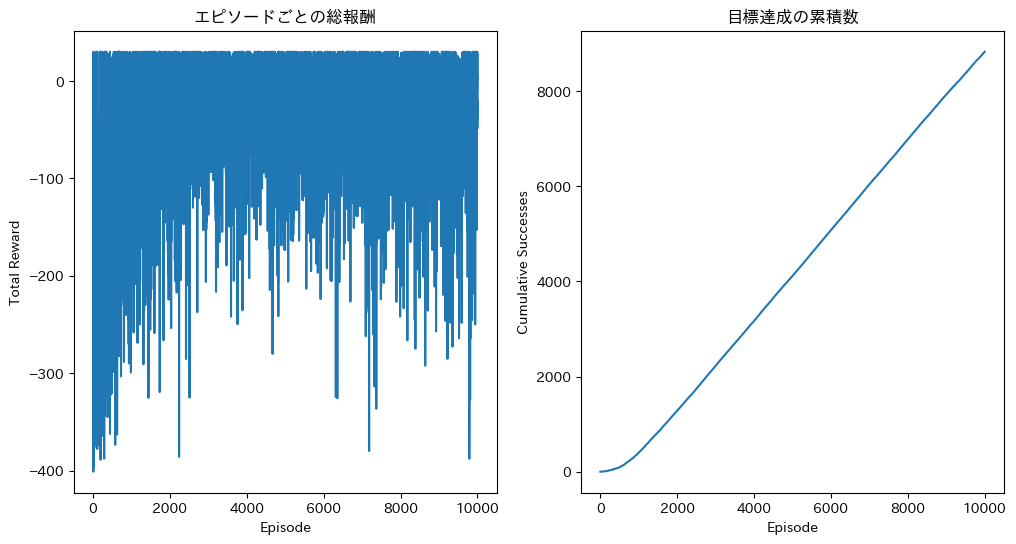

In [9]:
steps = np.arange(0, len(logs['rewards']))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(steps, logs['rewards'])
plt.title('エピソードごとの総報酬')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.subplot(1, 2, 2)
plt.plot(steps, np.cumsum(logs['finished']))
plt.title('目標達成の累積数')
plt.xlabel('Episode')
plt.ylabel('Cumulative Successes')

In [10]:
# モデルの保存
torch.save(model.state_dict(), './model/dqn_model.pth')
print("モデルを保存しました: dqn_model.pth")

モデルを保存しました: dqn_model.pth


In [12]:
# 可視化

# 可視化クラスの実体化
viewer = ArmViewer()
viewer.render((0, 0), (0.5, 0), (1, 0), (0.5, 1),
                info_lines=["Test Arm Viewer", "Click to set goal"])

# モデルの取得
model.load_state_dict(torch.load('./model/dqn_model.pth'))
print("モデルを読み込みました: dqn_model.pth")

running = True
done = True
goal_pos = (1, 0)  # 初期目標位置
model.eval()  # モデルを評価モードに設定
try:
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                # マウスクリック位置の座標を取得
                goal_pos = viewer.set_goal(pygame.mouse.get_pos())
                done = False

            # 目標値に到達するまでモデルに入れ続ける
            if not done:
                with torch.no_grad():
                    q_values = model(torch.FloatTensor(env.get_state()).unsqueeze(0))  # 状態をテンソルに変換
                    action = int(q_values.argmax(dim=1).item())

                # 環境にアクションを適用
                hand_xy, elbow_xy, done = env.step_sim(action)
                print(f"手の座標: {hand_xy}, 肘の座標: {elbow_xy}, 目標座標: {goal_pos}, done: {done}")

                # その座標を目標値としてモデルに入力
                viewer.render((0, 0), elbow_xy, hand_xy, goal_pos,
                            info_lines=["Click to set goal"])
        viewer.tick()
        pygame.time.delay(1)
except Exception as e:    
    # 発生中の例外に関する情報を取得する
    print(f"エラーが発生しました: {e}")
    pygame.quit()
    etype, value, tb = sys.exc_info()
    filename = tb.tb_frame.f_code.co_filename
    line_no = tb.tb_lineno
    raise Exception(f"{filename}の{line_no}行目でエラーが発生しました。詳細：{e}")
pygame.quit()

    




モデルを読み込みました: dqn_model.pth
手の座標: [0.9373481  0.33414297], 肘の座標: (np.float64(0.4521157836928172), np.float64(0.2135212357959502)), 目標座標: (0.9174603174603174, 0.14603174603174604), done: False
手の座標: [0.94303693 0.3177331 ], 肘の座標: (np.float64(0.45577338365919073), np.float64(0.20559820706380713)), 目標座標: (0.9174603174603174, 0.14603174603174604), done: False
手の座標: [0.9373481  0.33414297], 肘の座標: (np.float64(0.4521157836928172), np.float64(0.2135212357959502)), 目標座標: (0.9174603174603174, 0.14603174603174604), done: False
手の座標: [0.94303693 0.3177331 ], 肘の座標: (np.float64(0.45577338365919073), np.float64(0.20559820706380713)), 目標座標: (0.9174603174603174, 0.14603174603174604), done: False
手の座標: [0.9373481  0.33414297], 肘の座標: (np.float64(0.4521157836928172), np.float64(0.2135212357959502)), 目標座標: (0.9174603174603174, 0.14603174603174604), done: False
手の座標: [0.94303693 0.3177331 ], 肘の座標: (np.float64(0.45577338365919073), np.float64(0.20559820706380713)), 目標座標: (0.9174603174603174, 0.146031746031746